In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sys
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [19]:
data_path = '../data/preprocessed_data_2010_2025.csv'

In [20]:
df = pd.read_csv(data_path)

In [21]:
df.head()

,Datetime,Temperature,Wind Speed,Condition_Blowing Sand,Condition_Cloudy,Condition_Drizzle,Condition_Duststorm,Condition_Fair,Condition_Fog,Condition_Freezing Rain,...,Condition_Small Hail,Condition_Smoke,Condition_Snow,Condition_Snow Grains,Condition_Squalls,Condition_Thunder,Condition_Widespread Dust,Condition_Wintry Mix,WindDir_sin,WindDir_cos
0,2010-01-01 00:00:00,10.000000,7.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,-0.866025,-4.999999e-01
1,2010-01-01 01:00:00,10.000000,6.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,-1.000000,1.192488e-08
2,2010-01-01 02:00:00,10.000000,7.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,-0.939693,-3.420201e-01
3,2010-01-01 03:00:00,10.000000,7.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,-0.939693,-3.420201e-01
4,2010-01-01 04:00:00,11.111111,7.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,-0.939693,-3.420201e-01


In [22]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values('Datetime')
df = df.set_index('Datetime')

In [23]:
target = 'Temperature'
features = df.columns

In [24]:
split_date = '2022-1-1'
train_df = df.loc[:split_date]
test_df = df.loc[split_date:]

In [25]:
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

In [26]:
X_train = X_scaler.fit_transform(train_df[features])
X_test = X_scaler.transform(test_df[features])

In [27]:
y_train = y_scaler.fit_transform(train_df[[target]])
y_test = y_scaler.transform(test_df[[target]])

In [30]:
WINDOW = 24

In [31]:
def make_sequence(X, y, window=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])

    return np.array(X_seq), np.array(y_seq)

In [32]:
X_train_seq, y_train_seq = make_sequence(X_train, y_train, window=WINDOW)

In [33]:
X_test_seq, y_test_seq = make_sequence(X_test, y_test, window=WINDOW)

In [42]:
model = Sequential([
    Input(shape=(X_test_seq.shape[1],X_test_seq.shape[2])),
    SimpleRNN(64,activation='relu'),
    Dense(1, activation='linear')
])

In [43]:
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

In [44]:
model_checkpoint = ModelCheckpoint(
    '../models/rnn_best_model_full.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

In [45]:
model.fit(X_train_seq,
          y_train_seq,
         validation_split=0.1,
         epochs=25,
         batch_size=32,
         callbacks=[model_checkpoint])

Epoch 1/25
2931/2931 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0024 - mae: 0.0303 - val_loss: 7.8987e-04 - val_mae: 0.0204
Epoch 2/25
2931/2931 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.2153e-04 - mae: 0.0199 - val_loss: 7.9711e-04 - val_mae: 0.0207
Epoch 3/25
2931/2931 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.1507e-04 - mae: 0.0183 - val_loss: 7.3655e-04 - val_mae: 0.0194
Epoch 4/25
2931/2931 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 5.6685e-04 - mae: 0.0176 - val_loss: 5.7478e-04 - val_mae: 0.0169
Epoch 5/25
2931/2931 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 5.5208e-04 - mae: 0.0173 - val_loss: 6.1187e-04 - val_mae: 0.0170
Epoch 6/25
2931/2931 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 5.2712e-04 - mae: 0.0169 - val_loss: 5.5080e-04 - val_mae: 0.0166
Epoch 7/25
2931/2931 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 5.2170e-04 - mae: 0.0167 - val_loss: 8.1995e-04 - val_mae: 0.0215
Epoch 8/25
2931/2931 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 5.1246e-04 - mae: 0.0166 - val_loss: 5.2498

In [47]:
y_pred_scaled = model.predict(X_test_seq)

1089/1089 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [48]:
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test_seq)

In [50]:
mae = mean_absolute_error(y_true,y_pred)

In [51]:
mse = mean_squared_error(y_true,y_pred)

In [55]:
print(f'{mae= :.3f} , {mse= :.3f}')

mae= 0.768 , mse= 1.069


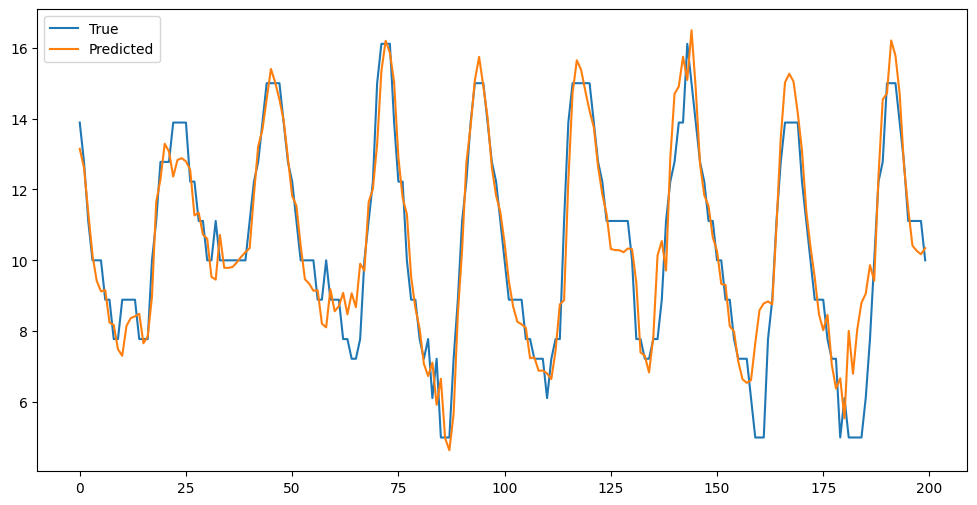

In [59]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(y_true[-200:], label='True')
ax.plot(y_pred[-200:], label='Predicted')
plt.legend()
plt.show()